# KaggleのDigit Recognizerというコンペティションに挑戦
https://www.kaggle.com/competitions/digit-recognizer

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#再現性を保つためにseedを固定
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# GPUが使えれば使う
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda')

## データセットの中身を確認

In [58]:
train = pd.read_csv("Dataset/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [59]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## pytorchのtensor型に変換する

In [60]:
train_label = torch.tensor(train["label"], dtype=torch.long).to(device)
train_data = torch.tensor(train.drop("label", axis=1).values, dtype=torch.float32).to(device)
print(train_label)

tensor([1, 0, 1,  ..., 7, 6, 9], device='cuda:0')


In [61]:
print(train_label.shape)
print(train_data.shape)

torch.Size([42000])
torch.Size([42000, 784])


In [62]:
train_data.max()

tensor(255., device='cuda:0')

* 0~1の実数に正規化

In [63]:
train_data /= 255
train_data.max()

tensor(1., device='cuda:0')

* trainデータの80%を学習用に、20%をテスト用に分ける

In [64]:
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size = 0.2, random_state = 0) 

train = TensorDataset(train_data, train_label)
valid = TensorDataset(valid_data, valid_label)

train_loader = DataLoader(train, batch_size = 128, shuffle=True)
valid_loader = DataLoader(valid, batch_size = 128, shuffle=False)

## MLPでモデルを作ってみる

In [65]:
# ハイパーパラメータ
INPUT_NUM = 784  # 入力の数
HIDDEN_NUM = 256 # 中間層の数
OUTPUT_NUM = 10  # 出力の数

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_NUM, HIDDEN_NUM)
        self.fc2 = nn.Linear(HIDDEN_NUM, HIDDEN_NUM)
        self.fc3 = nn.Linear(HIDDEN_NUM, OUTPUT_NUM)
    
    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        output = self.fc3(x)
        return output

model = MLP().to(device)

* 損失関数：クロスエントロピー
* 最適化アルゴリズム：Adam　

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [67]:
for epoch in range(50):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        correct = 0
        total = 0
        for images, labels in valid_loader: 
            outputs = model(images)
            predicted = torch.max(outputs.data, 1)[1]
            total += len(labels)
            correct += (predicted == labels).sum()
        accuracy = 100 * correct / float(total)
        print('Epoch: {}  Loss: {}  Accuracy: {}%'.format(epoch, loss.data, accuracy))

# model = torch.load('model_weight.pth')

Epoch: 0  Loss: 0.1318008154630661  Accuracy: 93.79761505126953%
Epoch: 5  Loss: 0.0071698809042572975  Accuracy: 97.08333587646484%
Epoch: 10  Loss: 0.005707450211048126  Accuracy: 97.33333587646484%
Epoch: 15  Loss: 0.0017520468682050705  Accuracy: 97.48809051513672%
Epoch: 20  Loss: 0.0010272571817040443  Accuracy: 97.57142639160156%
Epoch: 25  Loss: 0.00042224707431159914  Accuracy: 97.53571319580078%
Epoch: 30  Loss: 1.879251612990629e-05  Accuracy: 97.89285278320312%
Epoch: 35  Loss: 6.53347815386951e-05  Accuracy: 97.9047622680664%
Epoch: 40  Loss: 4.74209127787617e-06  Accuracy: 97.89285278320312%
Epoch: 45  Loss: 3.453211547821411e-06  Accuracy: 97.92857360839844%


In [ ]:
# 学習したモデルを保存
torch.save(model, 'model_weight.pth')

In [ ]:
# 検証データの推論
test_data = pd.read_csv("Dataset/test.csv")
test_data = torch.tensor(test_data.values, dtype=torch.float32).to(device)
with torch.no_grad():
    outputs = model(test_data)
    _, predicted = torch.max(outputs.data, 1)

predicted

tensor([2, 0, 9,  ..., 3, 9, 2], device='cuda:0')

In [ ]:
# ImageIdとLabelをデータフレーム化
test_result = pd.DataFrame( { 'ImageId': range(1, 28001) , 'Label': predicted.tolist() } )
print(test_result.head(10))

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
5        6      7
6        7      0
7        8      3
8        9      0
9       10      3


In [ ]:
# 生成したデータフレームをcsvとして保存
test_result.to_csv('Result/forsubmisson.csv', index=False)

## 正答率：97.76%
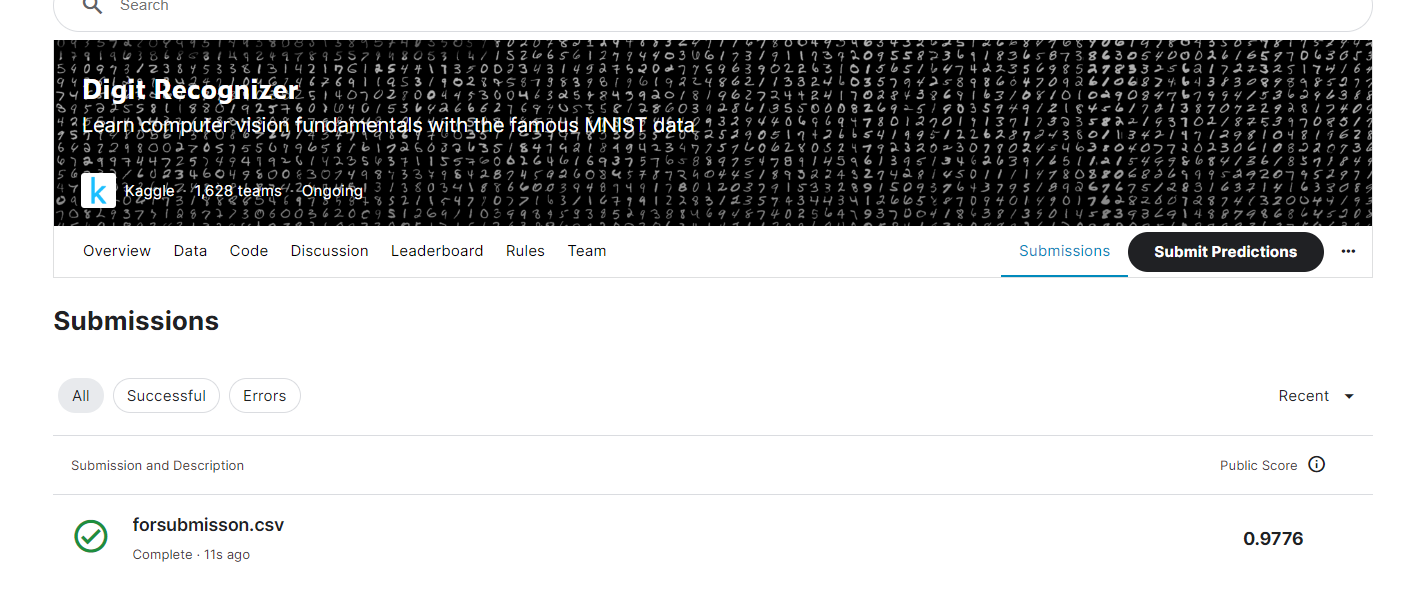

## しかしまだ1625人中1026位
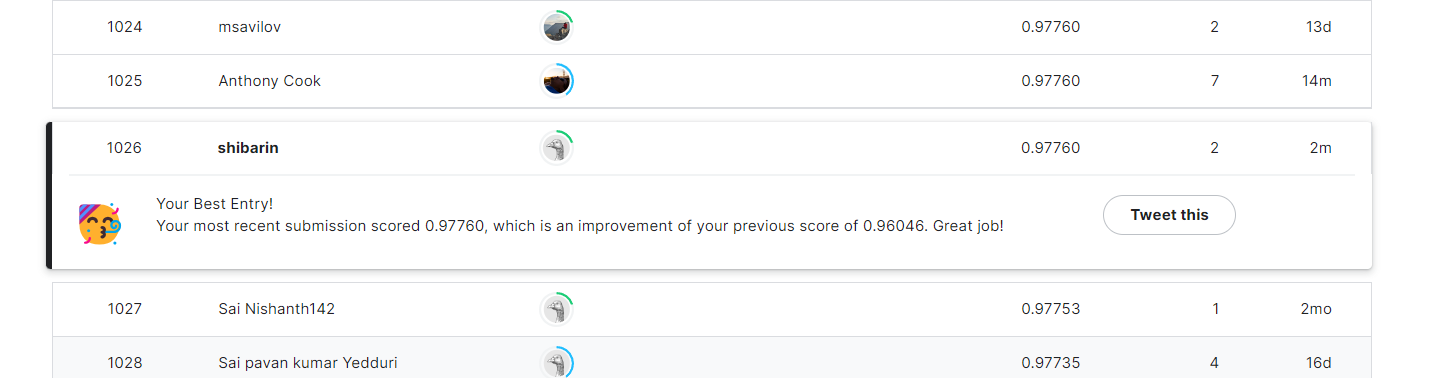
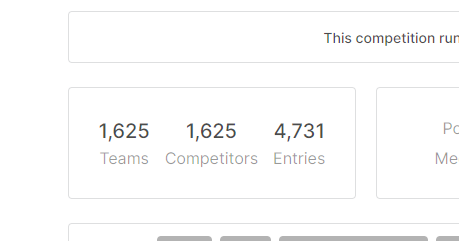